### Demonstration code on strategies for using DataFrames
The dataframe in this example is created based on theoretical curves of evaporation rates, but the same idea applies to files imported into dataframe structure, e.g. using pandas.read_csv()

I also include notes at the end speak to different tools/strategies used by Elise, Ben and Birgit for working with timeseries and, more specifically, DateTime.

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd

### Neat trick of using a dictionary to asign colors to line plot
Next step: Figure out how to loop through col. heads and automate the color assigment based on shades of a particular color

In [2]:
color_dict = {
    "Bunker-C (Anchorage-long term)":"yellowgreen",
    "Diesel": "mediumpurple",
    "ANKS": "sienna"
}

Text(0.5,0,'time [minutes]')

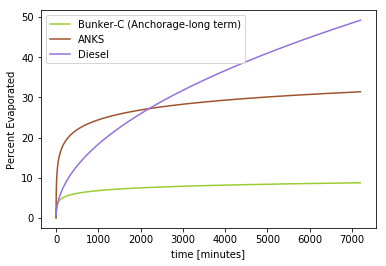

In [3]:
days = 5
time = [numpy.float(x) for x in range(1,60*24*days,1)]
SST = 15

evaporation = {'minutes':time, 
      'Bunker-C':(0.35 + 0.013 * SST) * numpy.sqrt(time), 
      'Bunker-C (bad)':(0.35 + 0.13 * SST) * numpy.sqrt(time),
      'Bunker-C (Anchorage-long term)':(0.31 + 0.045 * SST) * numpy.log(time),
      'ANKS': (2.86 + 0.045 * SST) * numpy.log(time),
      'Diesel': (0.31 + 0.018 * SST) * numpy.sqrt(time)
     } 
  
# Create DataFrame 
evaporation_df = pd.DataFrame(evaporation)

# plot evaporation rates
cols_plot = ['Bunker-C (Anchorage-long term)', 'ANKS', 'Diesel']
ax = evaporation_df[cols_plot].plot(
    linewidth=1.5,
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Percent Evaporated')
ax.set_xlabel('time [minutes]')

### "Waterhole" commentaries

#### Birgit
                           
You could try (pd is my alias for Pandas):

In [4]:
time = pd.Series(pd.date_range('2010-01-01 00:01:00', '2010-01-05 23:59:00', freq='min'))
# since the dataframe is already created, we can add a new col. simply by assigning it
# it will be asigned as the last col. I don't yet know how to change col. order
evaporation_df['datetime'] = pd.to_datetime(time)

In [5]:
len(evaporation_df['minutes'])

7199

In [6]:
len(evaporation_df['datetime'])

7199

After converting your list of time in minutes from a list of numpy floats to a list of datetime elements, you should abe able to plot it in Matplotlib using the lines you wrote:        
`Name_of_DataFrame[ column_names ].set_index('datetime').plot(linewidth=1.5)`
(This didn't work for me but the below does)

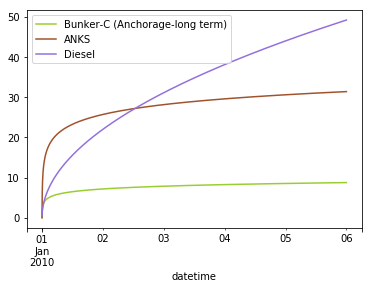

In [7]:
evaporation_df = evaporation_df.set_index('datetime') # note, you can't run this line a second time
evaporation_df[cols_plot].plot(
    linewidth=1.5,
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)

In [8]:
# This doesn't work.  Not sure why. Perhaps b/c I set index already.  
# x='minutes' doesn't work either
evaporation_df[cols_plot].plot(x='datetime', linewidth=1.5)

KeyError: 'datetime'

#### Elise:

I have found datetime to be generally compatible with pandas, with one exception: If I save a pandas dataframe using pickle, when I load it again the datetime values have been converted to numpy datetime64. 

Like Ben mentioned, using datetime on an x-axis in matlplotlib is seamless and allows you to apply a variety of types of formatting using matplotlib.dates:

In [ ]:
import matplotlib.dates as mdates
yearsFmt = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(yearsFmt)

Typically, I create a datetime column in my dataframes (named "df" below) as follows (assuming I have columns containing ‘Day’, ‘Month’ and ‘Year’):
```
import datetime as dt
#df is name of dataframe
df[‘dtUTC’]=[dt.datetime(yy,mm,dd) for yy,mm,dd in zip(df[‘Year’],df[‘Month'],df[‘Day’])]
#Similarly, for model output, 
fid=nc.Dataset(‘ModelOutput.nc’)
torig=dt.datetime.strptime(fid.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S’)
times=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])
```

#### Ben:
I have one potential solution for the date axis. It's not a one-liner, but I find it super useful in a lot of other ways. It's an Xarray trick I use but may apply to Pandas as well since Xarray uses Pandas under the hood. Xarray time objects are datetime64 which I believe is a Matplotlib convention, but I personally find it hard to work with. Datetime on the other hand is awesome, you can use timedelta, pass into plt.plot(), plus lot's of other intuitive stuff. Here's my workflow for converting Xarray datetime64 to datetime (I think this would work for a Pandas time column too).

***
```
import xarray as xr
from datetime import datetime, timedelta

ds = xr.open_dataset(filename)
time = ds.time.values
print(type(time[0]))  # Should be datetime64

time_datetime = time.astype('datetime64[s]').astype(datetime)
print(type(time_datetime[0]))  # Should be datetime

# Now the plot should have an intuitive time axis
fig, ax = plt.subplots()
ax.plot(time_datetime, ds.variable_name.values)

# I can also use datetime to reference the time axis
ax.set_xlim([datetime(y, m, d), datetime(y, m, d)])
```

NOTE [Rachael]: The reason why I opted for the dataframe approach is because the xarray method would require a new "ax.plot" line for each "variable_name" as opposed to having a list of variable names in a column that that just require one line to plot up